# Codebook

This notebook serves as an introduction to the data set, detailing its features, providing a statistical summary and offering some insights by performing a "first pass" Exploratory Data Analysis to highlight certain aspects. Please note that the code is in `R`.

## Setup

Package loading:

In [1]:
require(pacman) # package manager
pacman::p_load( # This is equivalent to library (+install.packages if needed)
  # File path constructor (auto root dir determination)
  here,
  # Read in data
  readr,
  # Data wrangling
  dplyr, forcats, tidyr, purrr,
  # Machine learning  and statistical generation for convenience
  mlr,
  # Plotting
  ggplot2, corrplot, viridis, ggthemes
)

# Set theme for ggplot2 output
theme_set(theme_few())

Loading required package: pacman



Load the data set:

In [2]:
data <- read_tsv(here::here("Data","Data.txt")) # automatic type inferance for the underlying data

Parsed with column specification:
cols(
  .default = col_double(),
  Label = col_character(),
  Ident = col_character(),
  Status = col_character()
)

See spec(...) for full column specifications.



How many observations and features (respectively) have been read in?

In [3]:
data %>% dim()

[1] 5058   58

## Features & Pre-processing

The some of the column of the data set are not necessarily a feature in the machine learning sense. Some of the features explained bellow are prefixed with `*` because they mostly pertain to thumbnail extraction. Others are prefixed with `-`, as they are relevant to Marine Scotland's workflow processes but not to the classificationj task it self. 

Without further ado, here's the description for each column in the data set:

1. `-`!Item: Line identifier from source (pid) files.
1. `-`Label: Scan identifier (used to link back to scanning metadata).
1. Area: Surface of the particle in square pixel.
1. Mean: Average grey value within the particle; this is the sum of the grey values of all the pixels in the particle divided by the number of pixels.
1. StdDev: Standard deviation of the grey value used to generate the mean grey value.
1. Mode: Most frequently occurring grey value within the particle.
1. Min: Minimum grey value within the particle (0 = black).
1. Max: Maximum grey value within the particle (255 = white).
1. `*`X: X coordinate of the centre of gravity of the particle.
1. `*`Y: Y coordinate of the centre of gravity of the particle.
1. `*`XM: X coordinate of the centre of gravity of the grey level in the particle.
1. `*`YM: Y coordinate of the centre of gravity of the grey level in the particle.
1. Perim: Perimeter --- the length of the outside boundary of the particle.
1. `*`BX: X coordinate of the top left point of the smallest rectangle enclosing the particle (used to extract thumbnails).
1. `*`BY: Y coordinate of the top left point of the smallest rectangle enclosing the particle (used to extract thumbnails).
1. `*`Width: Width of the smallest rectangle enclosing the particle (used to extract thumbnails).
1. `*`Height: Height of the smallest rectangle enclosing the particle (used to extract thumbnails).
1. Major: Primary axis of the best fitting ellipse to the particle.
1. Minor: Secondary axis of the best fitting ellipse to the particle.
1. `*`Angle: Angle between the primary axis and a line parallel to the x-axis of the image (used to get particle positioning).
1. Circ: $\textrm{Circularity}=4\pi\textrm{Area}/\textrm{Perimeter}^2$; a value of 1 indicates a perfect circle, a value approaching 0 indicates an increasingly elongated polygon.
1. Feret: The maximum Feret's diameter, i.e. the longest distance between any two points along the particle boundary.
1. IntDen: Integrated density, the sum of the grey values of the pixels in the particle, i.e. $\textrm{IntDen}=\textrm{Area} \times \textrm{Mean}$.
1. Median: Median of the grey values used to generate the mean grey value.
1. Skew: Skewness of the grey values, measuring lack of symmetry.
1. Kurt: Kurtosis of the grey values, measuring how tail-heavy the distribution is. Usually correlated with peaked or flat deviation from normal distribution (see [@kurtosisPaper]).
1. %Area: Surface of holes expressed as percentage.
1. `*`XStart: X coordinate of the top left point of the image (used to locate particle).
1. `*`YStart: Y coordinate of the top left point of the image (used to locate particle).
1. Area_exc: Surface of the particle excluding holes in square pixels ($=\textrm{Area}\times(1-(\textrm{\%Area}/100)$).
1. Fractal: Fractal dimension of particle boundary.
1. Skelarea: Area of skeleton in square pixels.
1. Slope: Slope of the grey level normalized cumulative histogram.
1. Histcum1: value at 0.25 quantile of the grey level histogram.
1. Histcum2: value at 0.50 quantile of the grey level histogram.
1. Histcum3: value at 0.75 quantile of the grey level histogram.
1. XMg5: X position of the centre of gravity of the particle, using a gamma value of 51. Always `0` in the data set...
1. YMg5: Y position of the centre of gravity of the particle, using a gamma value of 51. Always `0` in the data set...
1. Nb1: Number of "objects" after thresholding to the 0.25 quantile of grey levels (coresponds to Histcum1).
1. Nb2: Number of "objects" after thresholding to the 0.50 quantile of grey levels (corresponds to Histcum2).
1. Nb3: Number of "objects" after thresholding to the 0.75 quantile of grey levels (corresponds to Histcum3).
1. `-`Compentropy:  Unused variable, set to `0` in the data set.
1. `-`Compmean: as above.
1. `-`Compslope: as above.
1. `-`CompM1: as above.
1. `-`CompM2: as above.
1. `-`CompM3: as above.
1. Symmetrieh: index of horizontal symmetry.
1. Symmetriev: index of vertical symmetry.
1. Symmetriehc: As Symmetrieh, but after thresholding to the level of histcum1.
1. Symmetrievc: As above, but for vertical symmetry.
1. Convperim: Perimeter of the convex hull of the particle.
1. Convarea: As above, but area instead of perimeter.
1. Fcons: Contrast of particle
1. ThickR: Thickness ratio, i.e. maximum thickness/mean thickness.
1. `-`Tag: Logical flag for workflow process to signify if a particle is taggable (not to be used for classification)
1. **Ident**: The target label.
1. `-`Status: Whether the entry is part of the learning data set or not. All observations in the data set are part of the learning set, ergo the only value present is `Learning`.

While the features `X`, `Y`, `XM` and `YM` refer to position in the image of the centre of gravity of the object (absolute and adjusted by grey value concentration respectively) and thus do not make sense to be used directly for classification, they are still useful for derived features and are kept at this time. Their usefulness stems from the fact that they serve as coordinates.

There are a number of possible derived features that may be of interest. These are:

* `Mean_exc`: representing the average grey value excluding holes within the particle, and defined as Mean_exc = IntDen/Area_exc
* `ESD`: the Equivalent Spherical Diameter, defined as ESD=$2 \times \sqrt{\textrm{Area}/\pi}$
* `Elongation`: also known as "ellipse" elongation, this refers to the ratio of the major and minor axes of the best fitting ellipse, defined as Elongation=Major/Minor
* `Range`: refers to the range of grey values within the particle, defined as Range=Max-Min
* `MeanPos`: describes where the mean of the grey values "sits" in relation to the extremes of the grey values' distribution. Defined as MeanPos=(Max-Mean)/Range
* `CentroidsD`: describes the distance between the geometric centre of the particle and the centre of mass (via grey values distribution). Defined with the usual distance formula: CentroidsD=$\sqrt{(XM-X)^2 + (YM-Y)^2}$
* `CV`: the coefficient of variation (also known as the relative standard deviation), expressed as a percentage. Defined as CV=$100\times(StdDev/Mean)$
* `SR`: Defined as SR=$100\times(StdDev/Range)$, expresses as a percentage the relationship of the standard deviation to the range.
* `PerimAreaexc`: the ratio of the perimeter (outside boundary of particle) and its area excluding any holes, defined as PerimAreaexc=Perim/Area_exc
* `FeretAreaexc`: as above, but using the Feret's diameter instead of the perimeter
* `PerimFeret`: defined as the ratio of the perimeter to Feret's diameter (Perim/Feret)
* `PerimMaj`: as above, but using the primary axis (Perim/Major)
* `Circexc`: as circularity, but using the area excluding holes, defined as Circexc=$(4\pi$ $\times$ Area_exc)/$Perim^2$
* `CDexc`: defined as $CentroidsD^2/Area_exc$, this is similar to circularity in that if the result of the division is 4/$\pi$, then it satisfies the area equation for a circle (Area=$\pi/4 \times Diameter^2$). This used the distance between the centre of mass and the geometrical centre, as defined previously.

Furthermore, the `Ident` column contains the target label, which in R needs to be encoded as a factor.

Based on the above:

In [4]:
data <- data %>%
  mutate(Mean_exc = IntDen / Area_exc, #create derived features
         ESD = 2 * sqrt(Area / pi),
         Elongation = Major / Minor,
         Range = Max - Min,
         MeanPos = (Max - Mean)/Range,
         CentroidsD = sqrt((XM - X)^2 + (YM - Y)^2),
         CV = 100 * (StdDev / Mean),
         SR = 100 * (StdDev / Range),
         PerimAreaexc = Perim. / Area_exc,
         FeretAreaexc = Feret / Area_exc,
         PerimFeret = Perim. / Feret,
         PerimMaj = Perim. / Major,
         Circexc = (4*pi*Area_exc) / Perim.^2,
         CDexc = (CentroidsD^2)/Area_exc
         ) %>% 
  select(-c( #remove unneeded features
          X, Y, XM, YM, `!Item`, Label,
          BX, BY, Width, XMg5, YMg5,
          Height, Angle, XStart, YStart,
          Status, Compentropy, Compmean,
          Compslope, CompM1,CompM2, CompM3,
          Tag, Status
  )) %>%
  mutate(Ident = as.factor(Ident)) %>% #convert to factor
  select(Ident, everything()) #re-arrange so that ident is the first column

The leaves us with 49 columns, i.e. 48 features and the target label:

In [5]:
data %>% names()

[1] "Ident"        "Area"         "Mean"         "StdDev"       "Mode"        
 [6] "Min"          "Max"          "Perim."       "Major"        "Minor"       
[11] "Circ."        "Feret"        "IntDen"       "Median"       "Skew"        
[16] "Kurt"         "%Area"        "Area_exc"     "Fractal"      "Skelarea"    
[21] "Slope"        "Histcum1"     "Histcum2"     "Histcum3"     "Nb1"         
[26] "Nb2"          "Nb3"          "Symetrieh"    "Symetriev"    "Symetriehc"  
[31] "Symetrievc"   "Convperim"    "Convarea"     "Fcons"        "ThickR"      
[36] "Mean_exc"     "ESD"          "Elongation"   "Range"        "MeanPos"     
[41] "CentroidsD"   "CV"           "SR"           "PerimAreaexc" "FeretAreaexc"
[46] "PerimFeret"   "PerimMaj"     "Circexc"      "CDexc"

### Statistical summary of features

For the following table, please note that:

* na: missing values,
* nlevs: number of unique values (for non-numeric features)

In [6]:
data %>% mlr::summarizeColumns() %>% select(-disp, -mad) %>% knitr::kable(digits = 2)



|name         |type    | na|       mean|    median|       min|          max| nlevs|
|:------------|:-------|--:|----------:|---------:|---------:|------------:|-----:|
|Ident        |factor  |  0|         NA|        NA|     52.00|       376.00|    24|
|Area         |numeric |  0|   37980.36|   4015.00|    631.00|    884694.00|     0|
|Mean         |numeric |  0|     206.78|    206.79|    120.17|       249.81|     0|
|StdDev       |numeric |  0|      30.04|     31.95|      0.75|        76.87|     0|
|Mode         |numeric |  0|     233.31|    249.00|      0.00|       255.00|     0|
|Min          |numeric |  0|     116.32|    112.00|      0.00|       247.00|     0|
|Max          |numeric |  0|     252.53|    253.00|    249.00|       255.00|     0|
|Perim.       |numeric |  0|    1550.69|    594.38|     94.08|     68099.09|     0|
|Major        |numeric |  0|     255.00|    102.36|     29.88|      2287.11|     0|
|Minor        |numeric |  0|     100.49|     51.65|      5.52|       940.2

There are no missing values, but also different scales are at play.

## Distributions of Features

Most of the features are **not** normally distributed, as can be seen below:

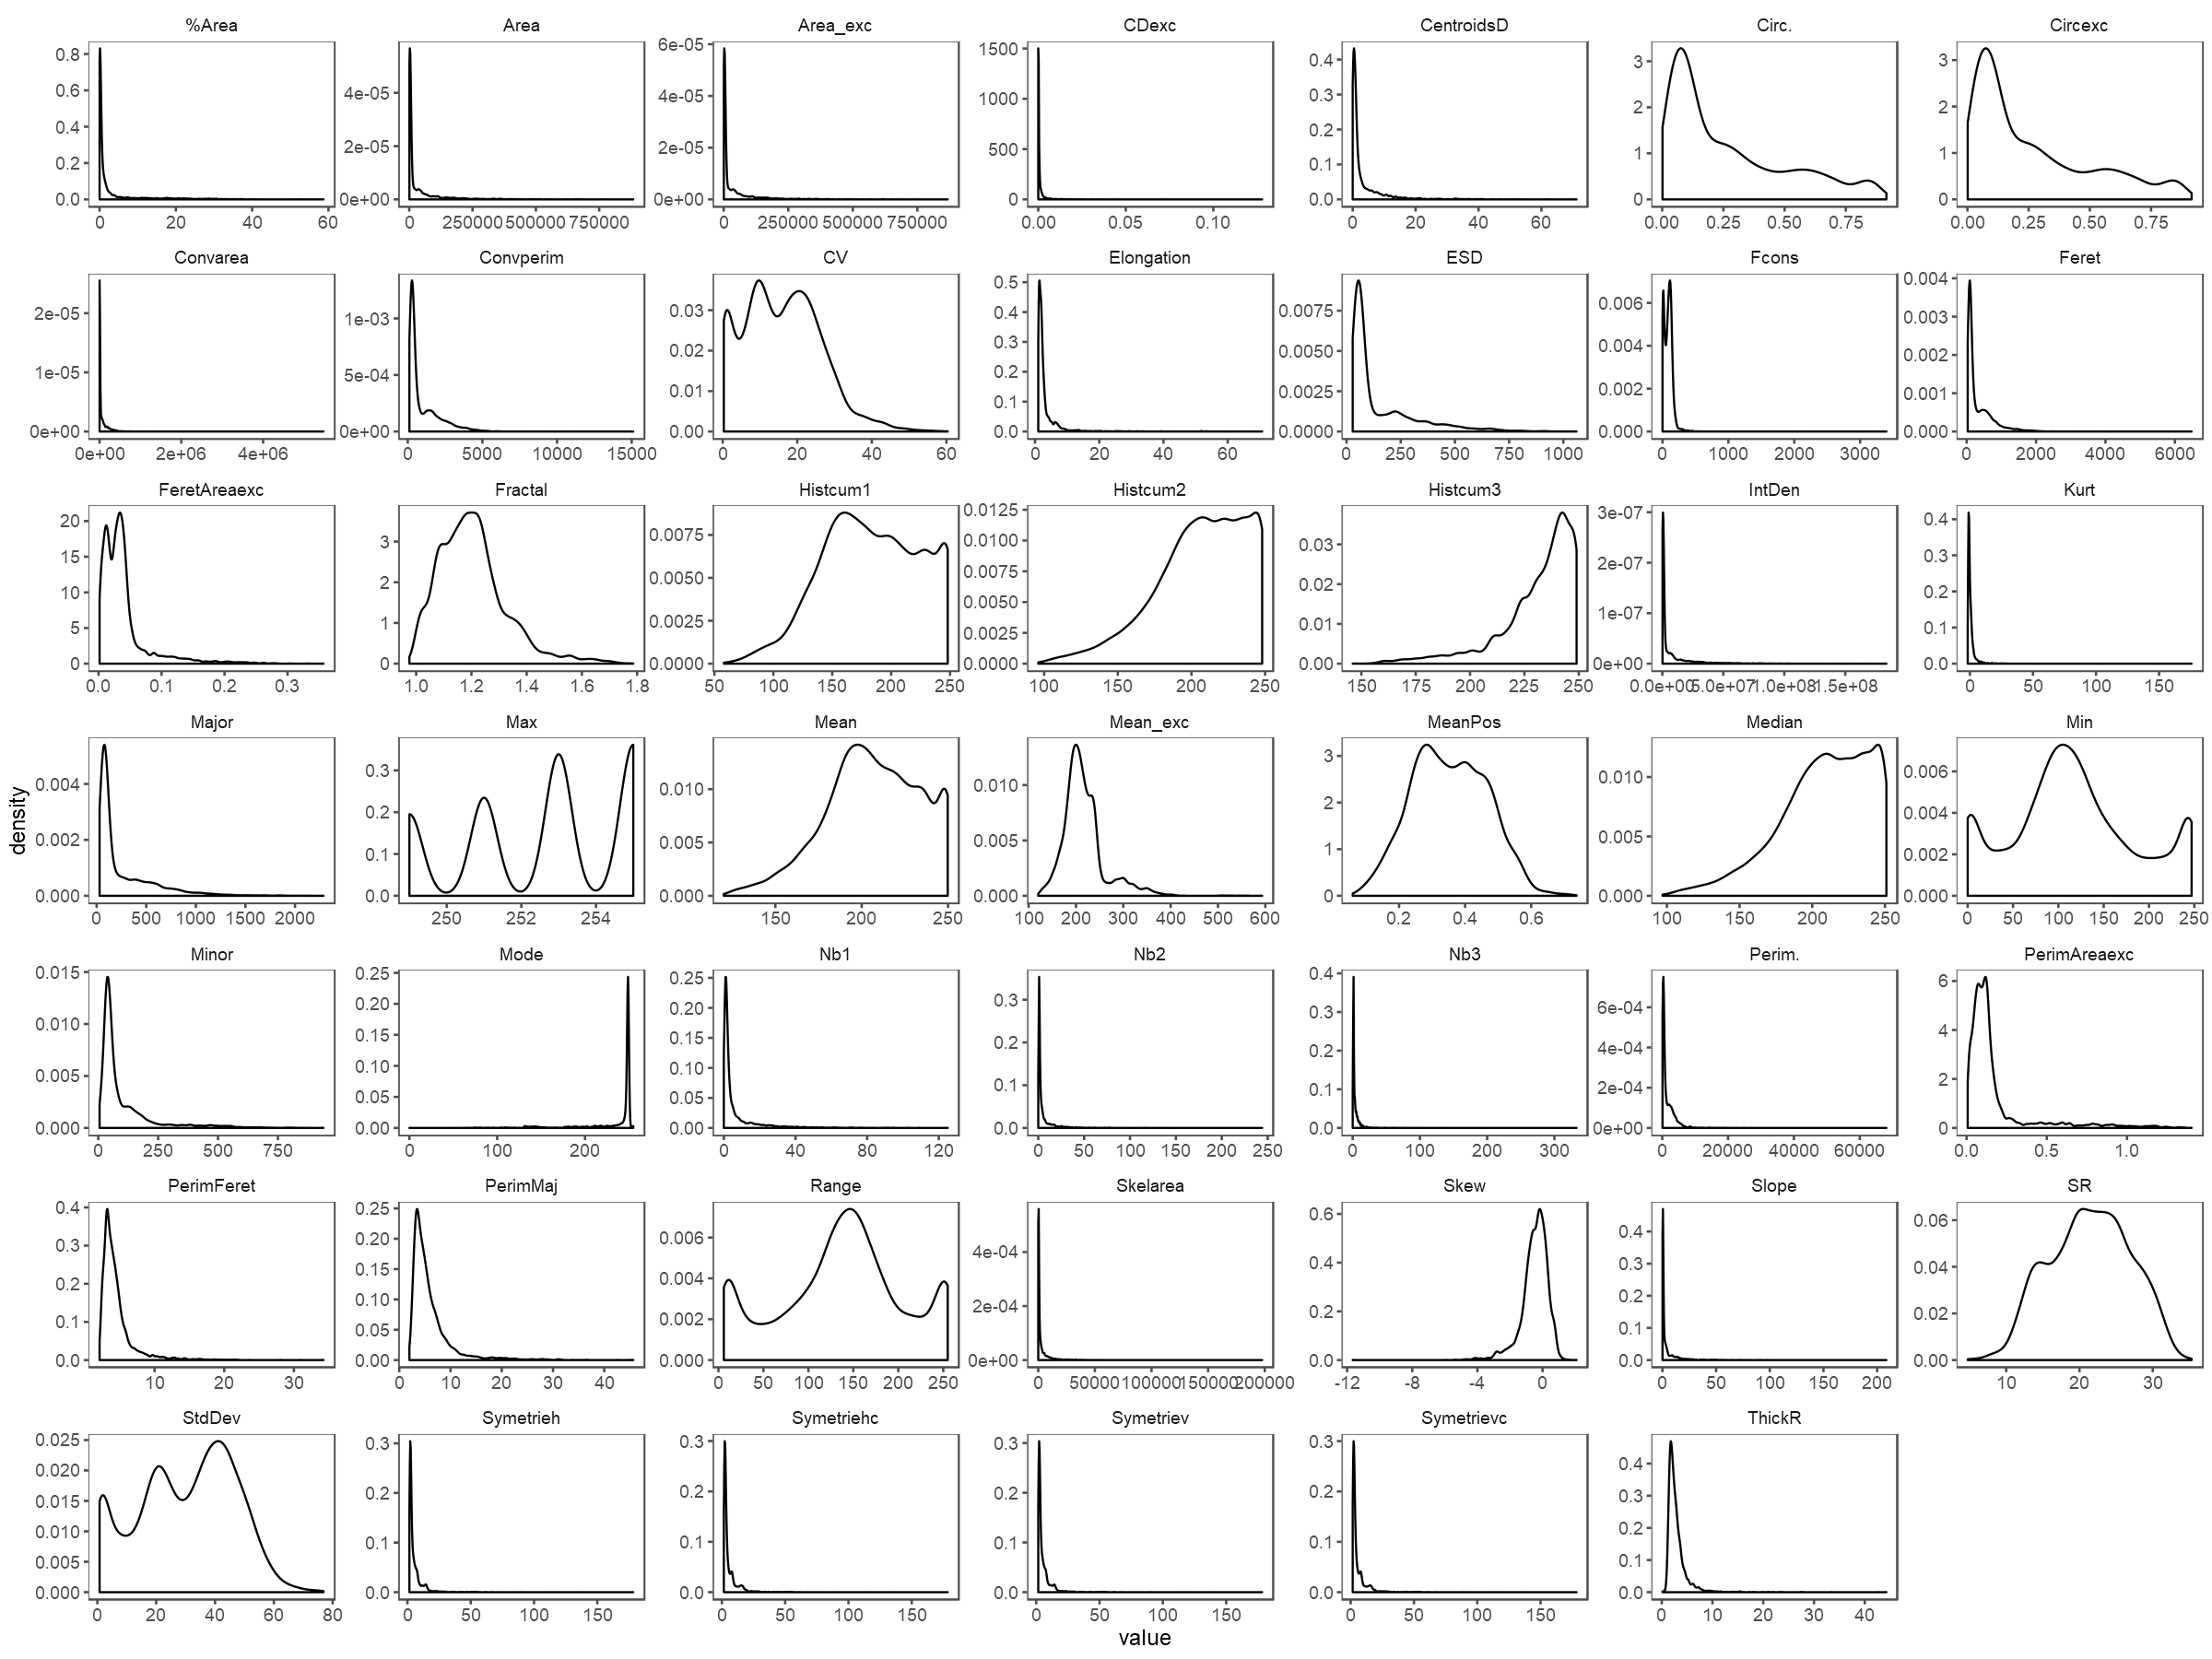

In [7]:
options(repr.plot.width=20, repr.plot.height=15) # Specify plot dimensions for jupyter notebook

data %>% 
  keep(is.numeric) %>%
  gather() %>%
  ggplot(aes(value)) +
    facet_wrap(~ key, scales = "free") +
    geom_density() +
    theme(text = element_text(size = 14))

## Corellations between features

*Weak correlations are filtered out in the next step.*

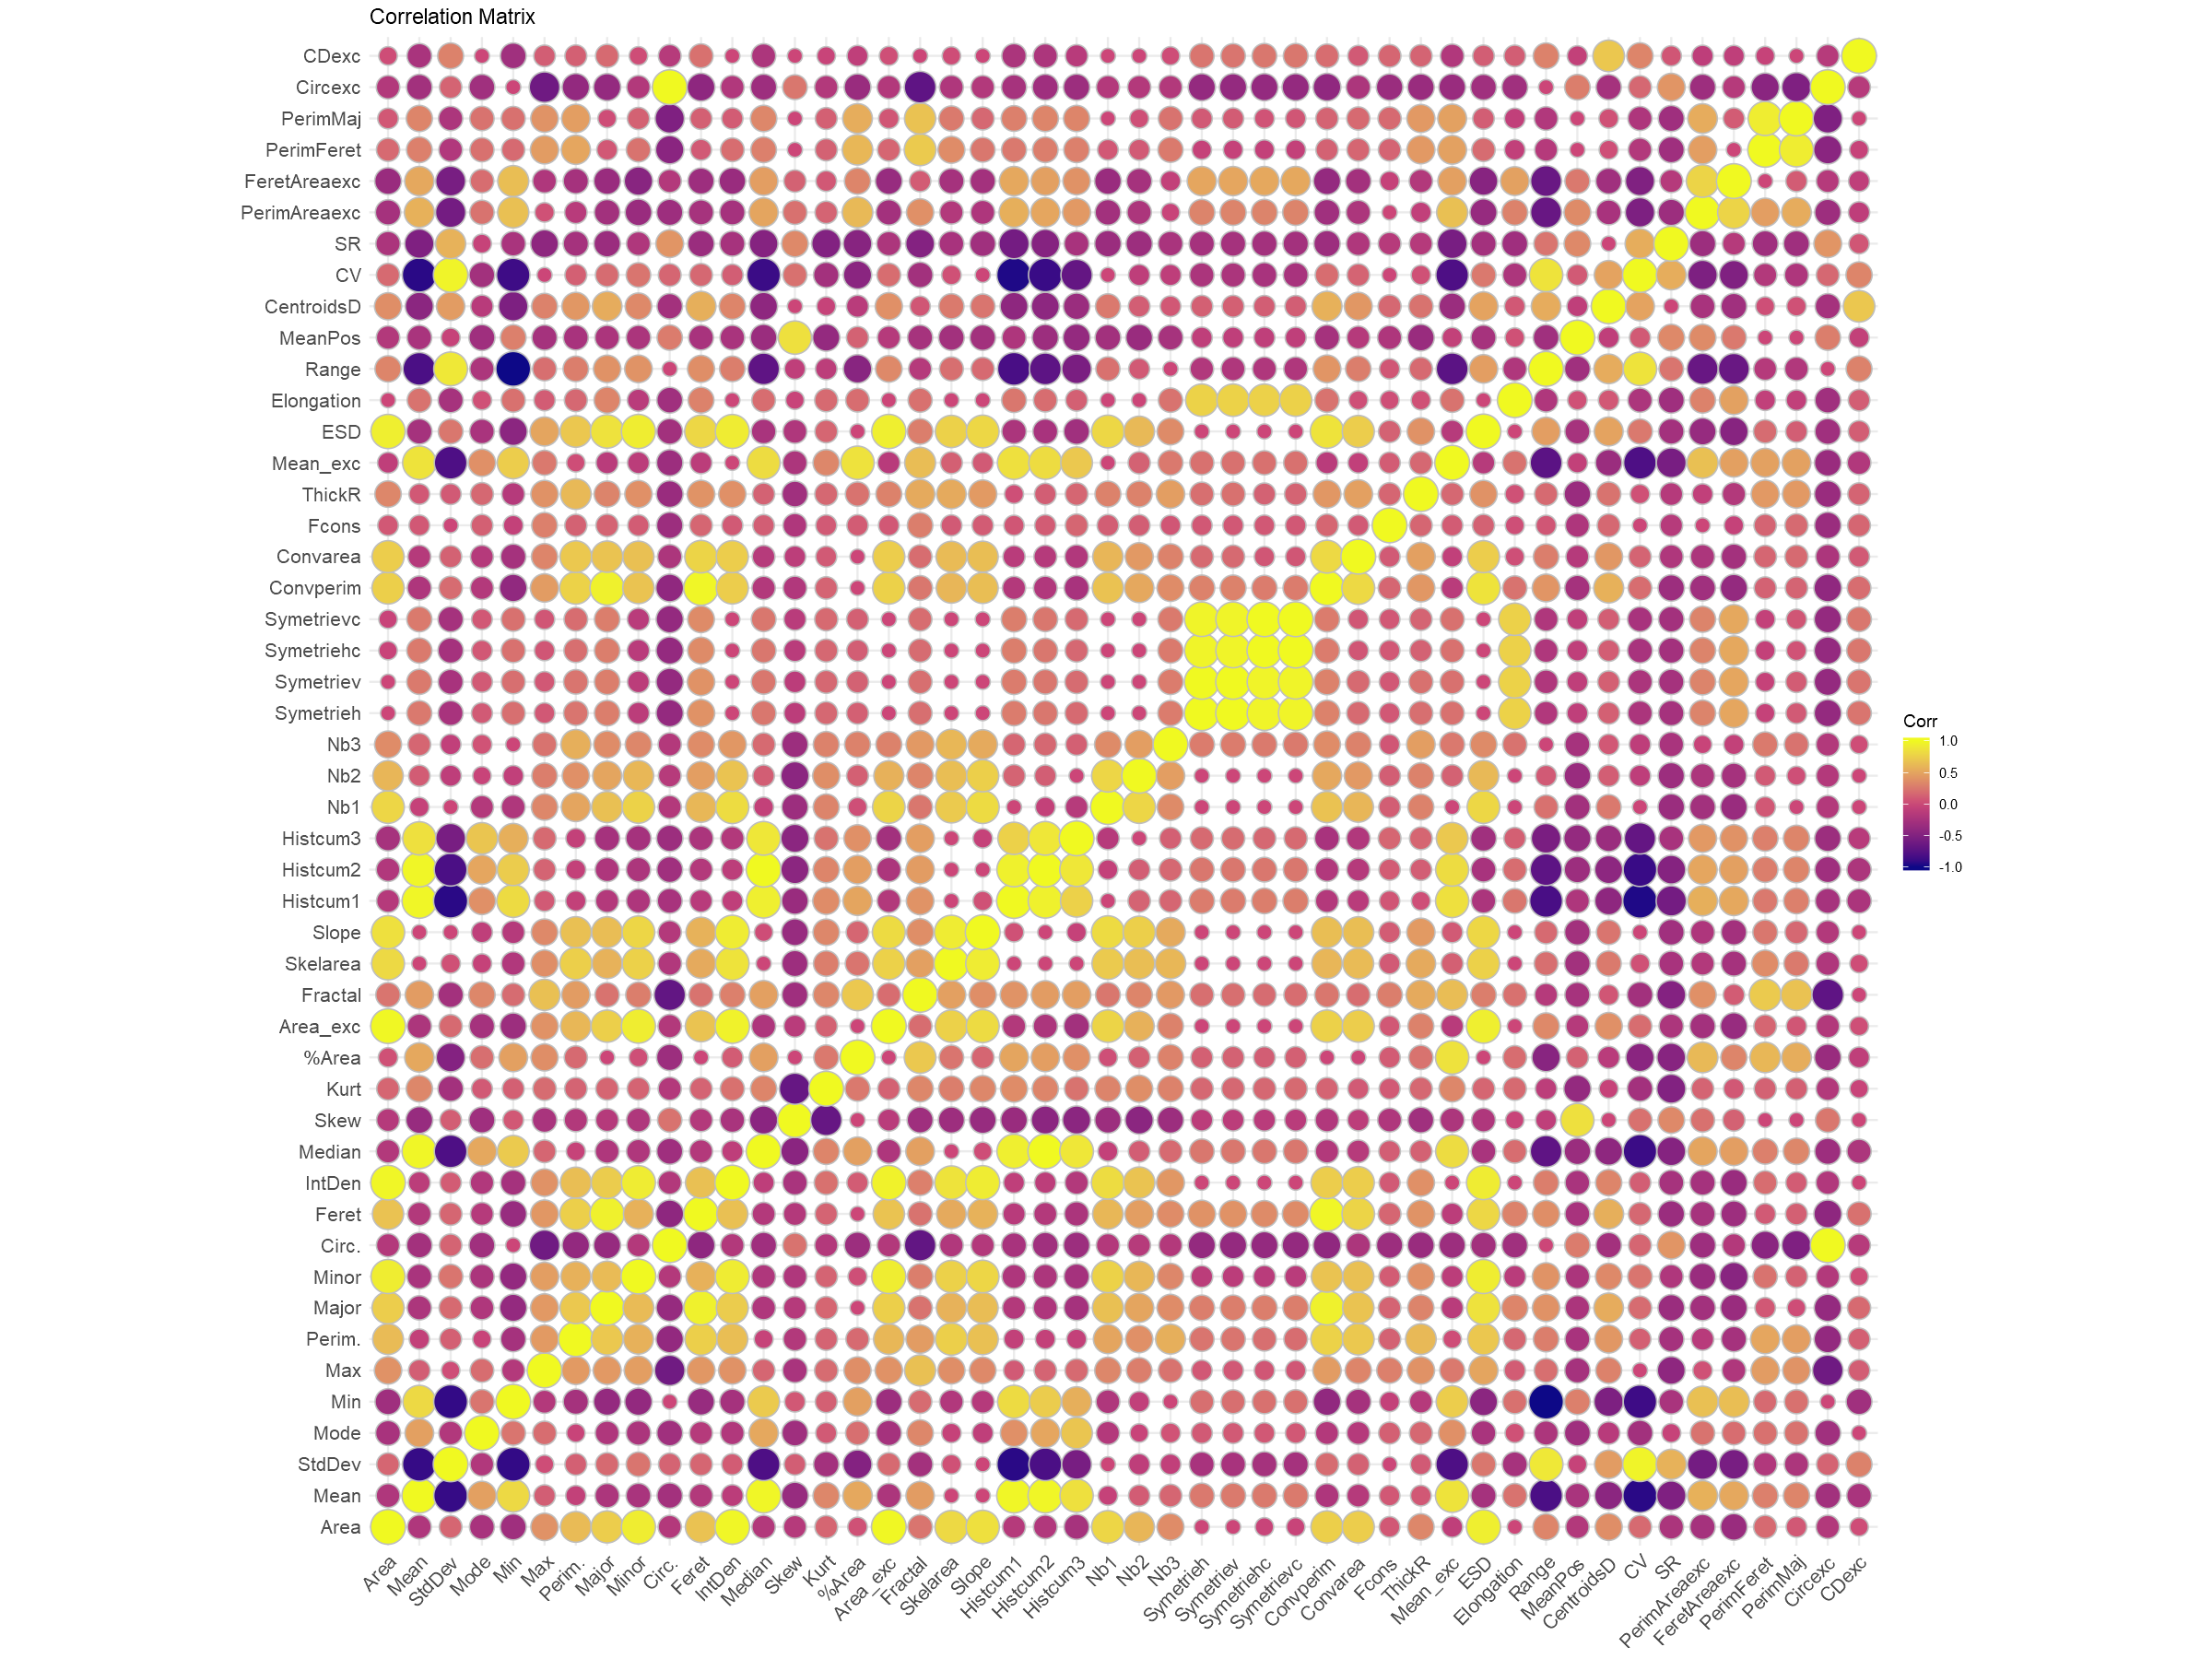

In [8]:
data %>%
  select(- Ident) %>% 
  cor() %>%   # calculate the corelation matrix
  ggcorrplot::ggcorrplot(., p.mat = ggcorrplot::cor_pmat(data[,2:ncol(data)]),
                         sig.level = 0.05, # signficance level threshold
                         insig = "blank",
                         method = "circle", type = "full",
                         show.diag = FALSE, lab = FALSE,
                         colors = viridis::plasma(3)
                         ) +
  ggtitle("Correlation Matrix")

All squares filled i.e. all correlations are significant at the level set (0.05).

### Focus on stronger correlations

Filter out weak correlations by arbitrarily setting a threshold, in this case, |correlation|>=0.8.

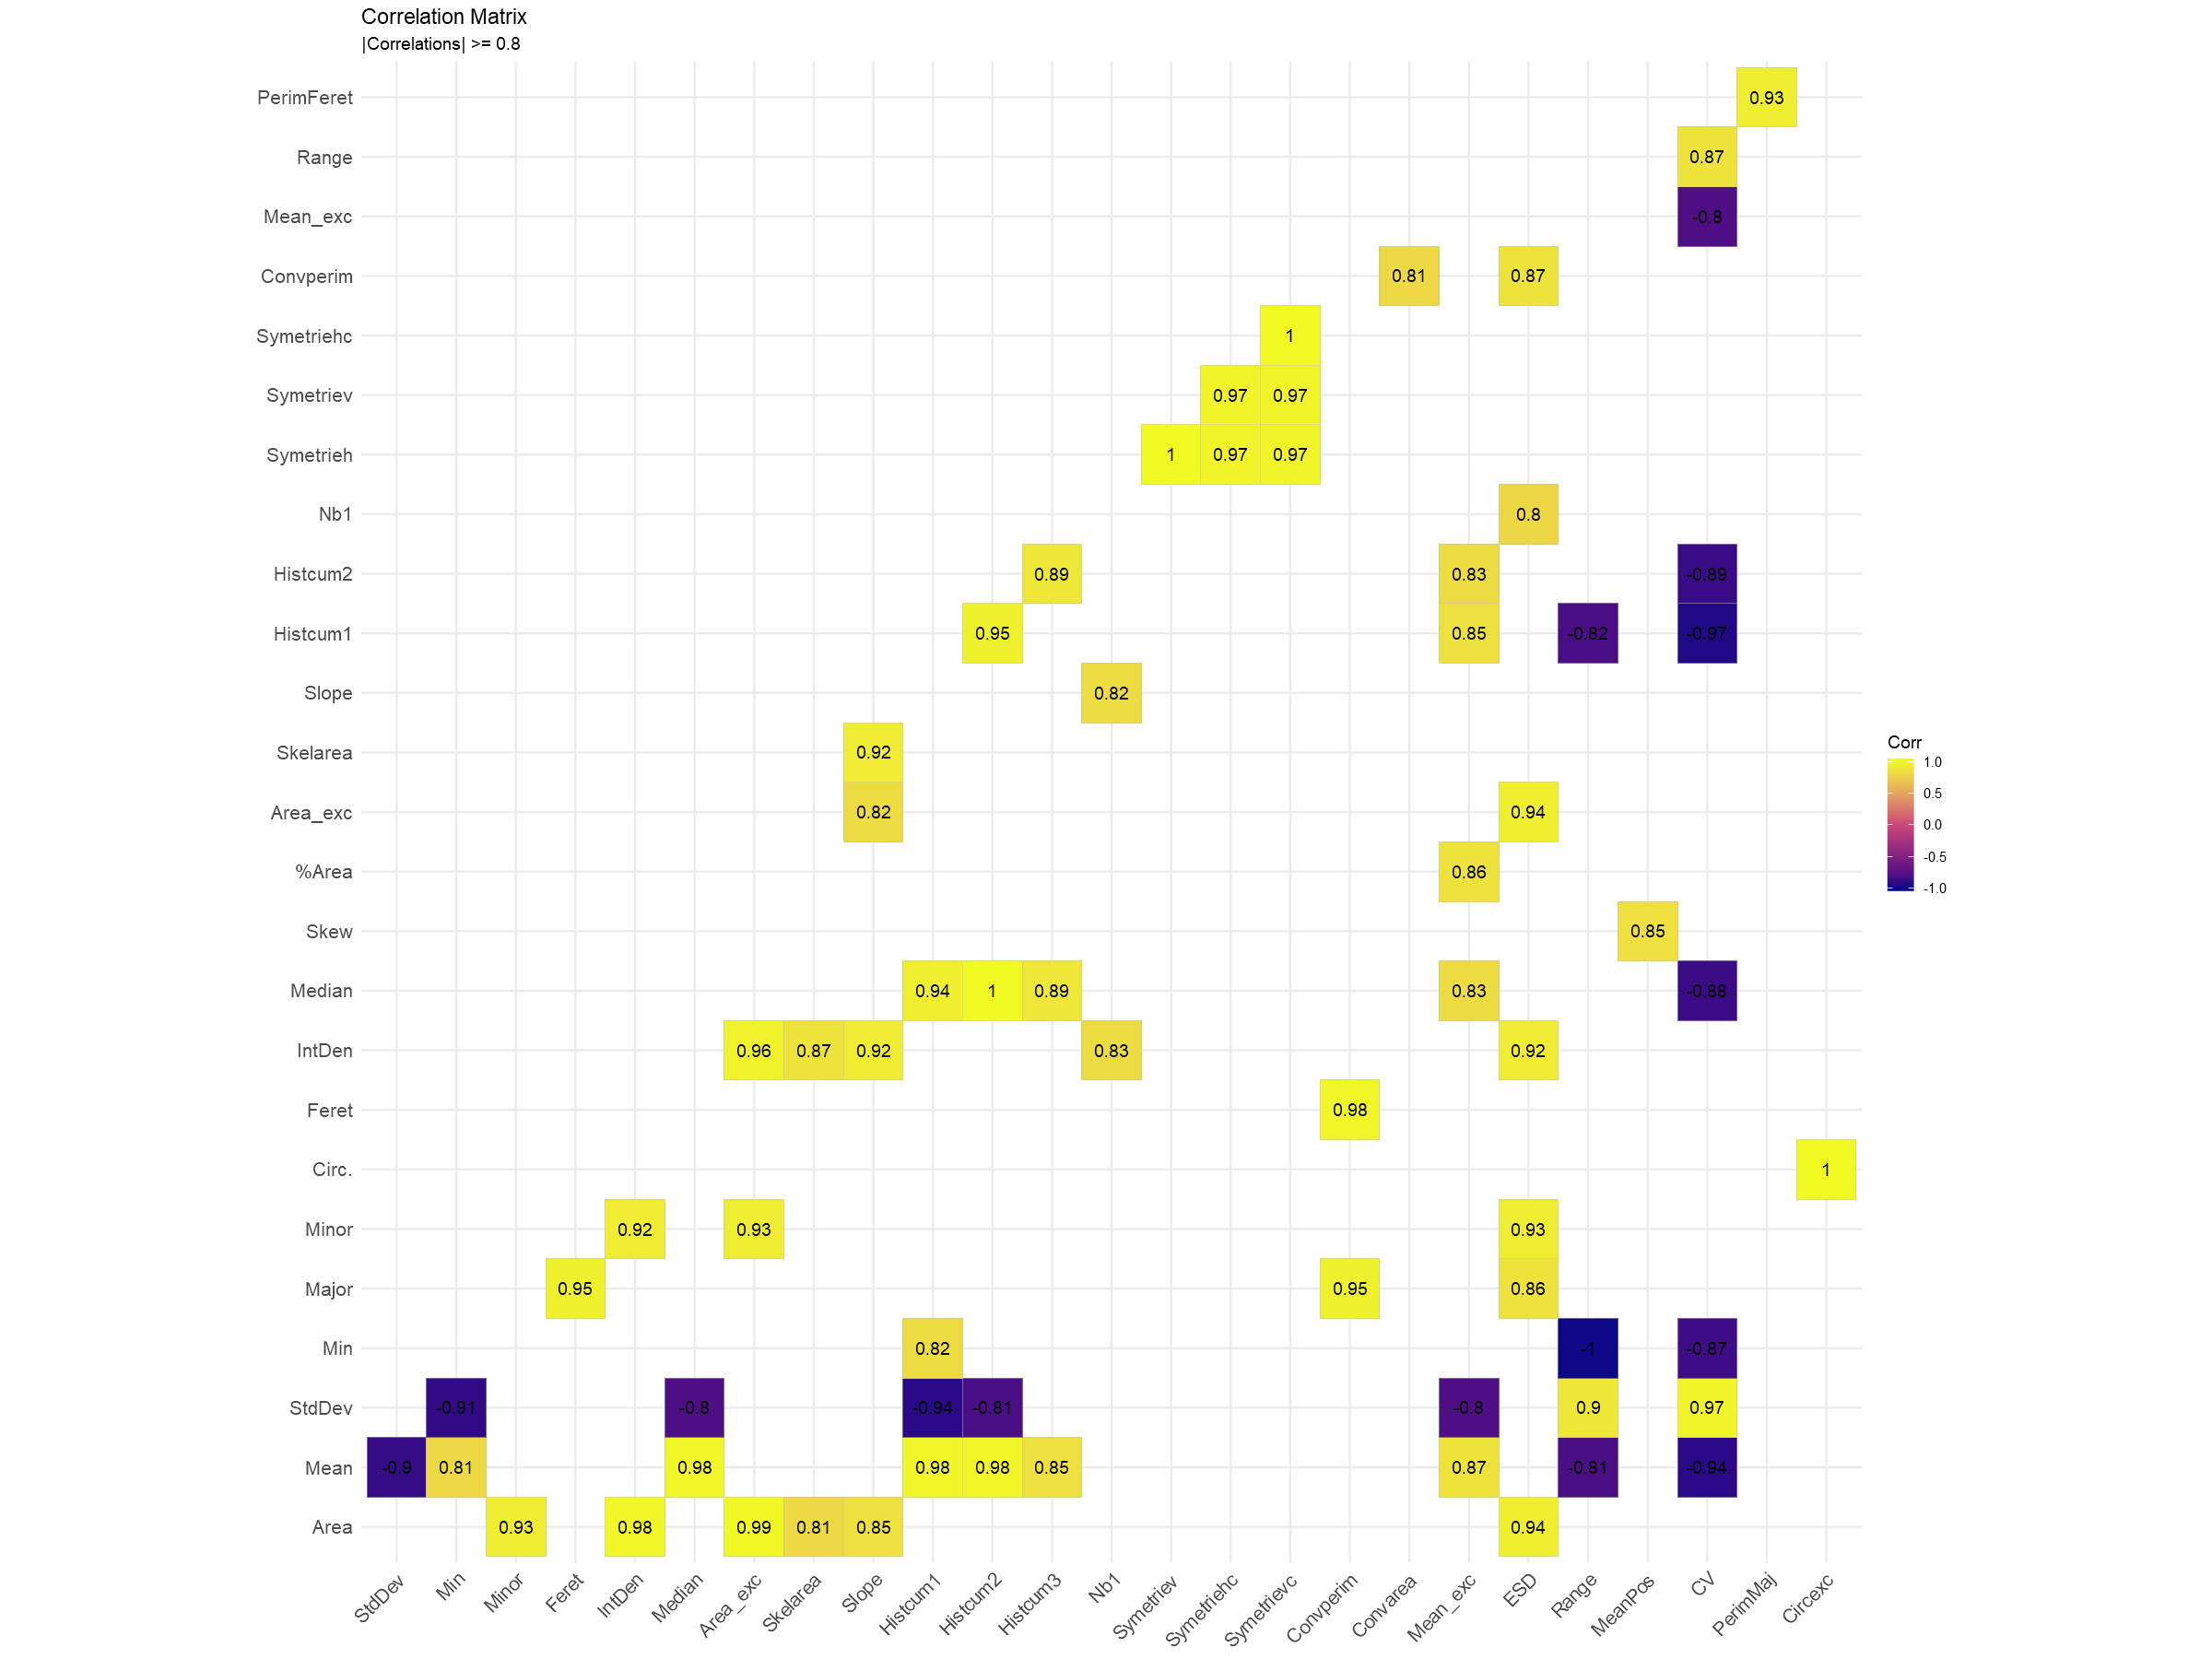

In [9]:
corrInteresting <- data %>% select(-Ident) %>% cor() # calculate correlation matrix
corrInteresting[-0.8<=corrInteresting & corrInteresting<=0.8] <- NA # assign NAs to weaker correlations

corrInteresting %>% # plot
  ggcorrplot::ggcorrplot(., method = "square", type = "lower", lab = TRUE,
                           colors = viridis::plasma(3)
                          ) +
  ggtitle("Correlation Matrix", subtitle = "|Correlations| >= 0.8")

# clean up
rm(corrInteresting)

## Target Label/Classes

The `Ident` column codifies the target label for prediction. The possible values and their respective number of cases are presented in the graph below, after the description of each label.

The labels can be grouped into biological (of domain significance) and non-Biological (of no importance). These are:

Non-biological:

  - Bad focus: particles that appear blurred.
  - Detritus: any type of non-biological material, various shapes and sizes.
  - Fiber: long thread like particles
  - Grey line and grey surface: areas of the scanned image that appear as grey background or line with a particle somewhere, however the dimensions include the grey area/line.
  - Multiple: particles that overlap, various combinations were included in the learning set.
   
Biological:

  1. Annelida: larval stages of  benthic worms (Polychaeta)
  1. Appendicularia: not very easy to describe, animals with roundish head and a transparent tail, Oikopleura dioika is the most common species at Stonehaven
  1. barn_cyprids: larval stages of barnacles
  1. barn_naupl: larval stages of barnacles
  1. Bryozoa: larval stage of benthic animals
  1. Chaetognatha: common name arrow worms, main species Parasagitta elegans.
  1. Cladocera: small crustaceans, mostly Podon spp. and Evadne spp.
  1. Cnidaria: small gelatinous zooplankton, not very easy to scan because they are fragile, mostly Aglantha digitale in the learning set, some smaller species included in the category.
  1. Copepoda: the main component of zooplankton, taxa used in the learning set are Calanus finmarchicus and helgolandicus, Temora longicornis, Pseudocalanus spp., Acartia clausi, Centropages hamatus and typicus, Candacia armata, Oithona similis.
  1. crust_larvae: larvae of decapoda (crabs and shrimps mostly) with two main types (megalopa and zoea). 
  1. Ctenophora: different group of gelatinous zooplankton, species present in samples and scanned was Pleurobrachia pileus.
  1. Egg: fish eggs
  1. Euphausiids: common name krill, main species Thysanoessa inemris and raschii.
  1. Gastropoda: larvae that look like snails.
  1. Hyperiids: planktonic amphipods, common species Hyperia galba.
  1. Pisces: Larval fish (multiple species).
  1. small_crust: Small crustaceans in the pre-metamorphosis stage.
  1. Tomopteris: polychaeta like the Annelidae, but adult animals with very different shape

Let's plot the number of observations for each class:

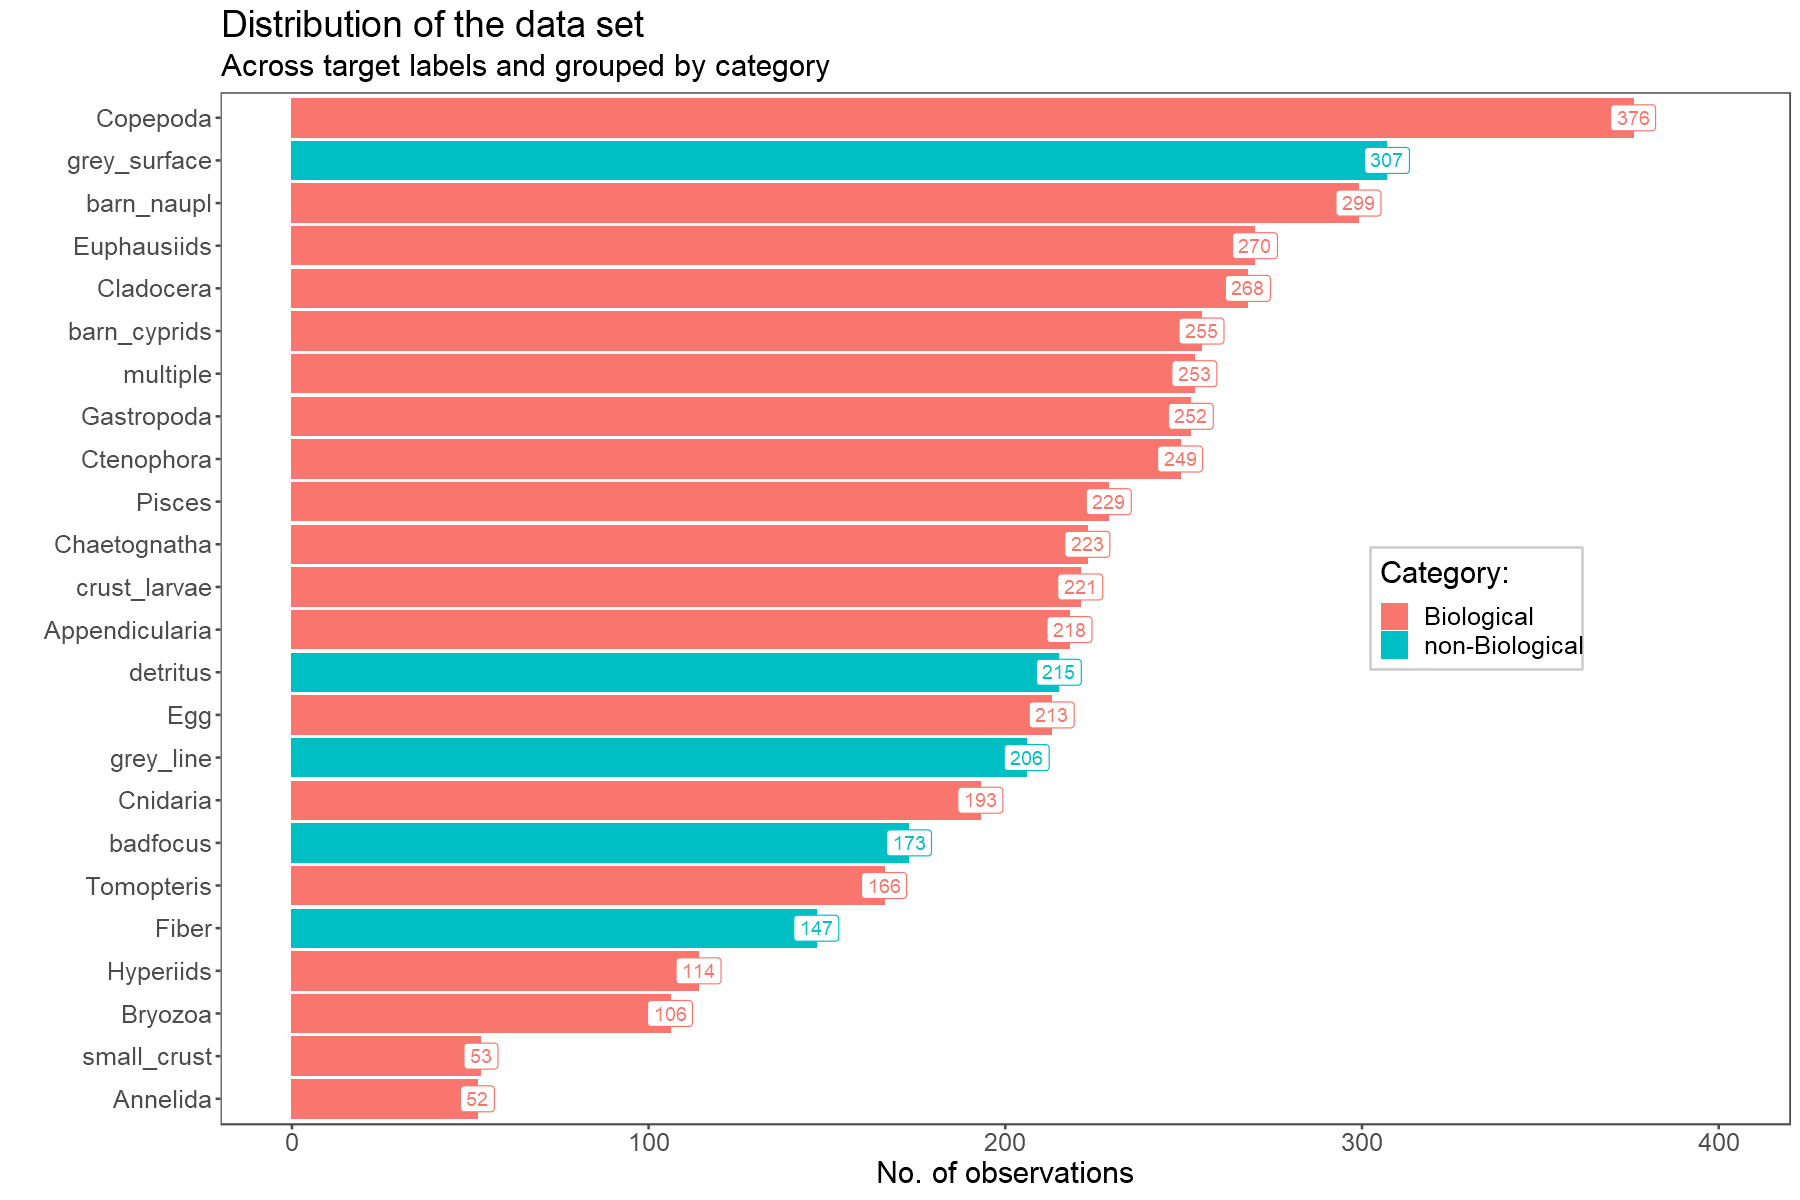

In [10]:
options(repr.plot.width=15, repr.plot.height=10) # Specify plot dimensions for jupyter notebook


# Create grouping of certain classes not being of biological importance:
nonBio <- c("badfocus", "detritus", "Fiber", "grey_line", "grey_surface")


# Plot no. of observations for each class
data %>% group_by(Ident) %>% summarise(cases = n()) %>% 
  mutate(category = 
           if_else(Ident %in% nonBio, "non-Biological", "Biological")
        ) %>% 
  mutate_if(~ is.character(.), ~ as.factor(.)) %>% # convert characters to factors
  ggplot(aes(fct_reorder(Ident, cases),
             cases, fill = category)) +
  geom_col() +
  geom_label(aes(label = cases, colour = category),
             fill = "white", show.legend = F) +
  theme(legend.position = c(0.8,0.5), text = element_text(size=18),
        legend.background = element_rect(fill = "white", colour = "#cccccc")) +
  ylim(0, 400) +
  labs(x = "", fill = "Category: ", y = "No. of observations",
       title = "Distribution of the data set",
       subtitle = "Across target labels and grouped by category"
      ) +
  coord_flip()

# Clean up
rm(nonBio)

Clearly, this is an imbalanced data set.